### Membagi data train dan data testing

In [1]:
import splitfolders

# Menentukan folder awal dari dataset citra
base_dir = './Dataset/Original_Dataset'

# Melakukan split data berdasarkan ukuran 80% dan 20%
splitfolders.ratio(base_dir, output='./Dataset', seed=1337, ratio=(.8, .2))

Copying files: 5080 files [00:16, 306.52 files/s]


### Menentukan preproses dan scaling data

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Menentukan scalling dan perubahan setiap data train
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'wrap'
                )

# Menentukan scalling dan perubahan setiap data test
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'wrap'
                )

### Menerapkan citra dengan auto labeling berdasarkan nama folder

In [3]:
train_dir = './Dataset/train'
validation_dir = './Dataset/val'

train_generator = train_datagen.flow_from_directory(
        train_dir,  # Direktori data latih
        target_size=(150, 150),  # Mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=32,
        class_mode='categorical')

Found 4063 images belonging to 3 classes.
Found 1017 images belonging to 3 classes.


### Membuat Model CNN

In [4]:
# import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50

modelCNN_ResNet = ResNet50(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
modelCNN_ResNet

In [5]:
for layer in modelCNN_ResNet.layers :
    layer.trainable = False

### Model Summary CNN ResNet50

In [6]:
modelCNN_ResNet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Membuat MLP Model

In [7]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(modelCNN_ResNet.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)

# Add a final sigmoid layer with 3 node for classification output
x = layers.Dense(3, activation='softmax')(x)

modelCNN_ResNet = Model(inputs=modelCNN_ResNet.input, outputs=x)

### Model CNN ResNet50 MLP Compile

In [8]:
import tensorflow as tf

# categorical_crossentropy --> Digunakan untuk citra yang lebih dari 3 class
# tf.optimizers.Adam() --> Cocok untuk citra dengan data yang cukup banyak

modelCNN_ResNet.compile(optimizer=tf.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

### Model CNN ResNet50 Summary

In [9]:
modelCNN_ResNet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### Latih Model CNN

In [11]:
history = modelCNN_ResNet.fit(
        train_generator,
        steps_per_epoch=40,  # Batch yang akan dieksekusi pada setiap epoch
        epochs=50,
        validation_data=validation_generator, # Menampilkan akurasi pengujian data validasi
        validation_steps=10,  # Batch yang akan dieksekusi pada setiap epoch
        batch_size=100,
        verbose=1 # Animasi perjalanan epoch
    )

Epoch 1/50
40/40 [==============================] - 63s 2s/step - loss: 1.0863 - accuracy: 0.4539 - val_loss: 0.8961 - val_accuracy: 0.5969
Epoch 2/50
40/40 [==============================] - 66s 2s/step - loss: 0.8630 - accuracy: 0.6367 - val_loss: 0.8844 - val_accuracy: 0.6406
Epoch 3/50
40/40 [==============================] - 70s 2s/step - loss: 0.8304 - accuracy: 0.6133 - val_loss: 0.7032 - val_accuracy: 0.7312
Epoch 4/50
40/40 [==============================] - 74s 2s/step - loss: 0.7392 - accuracy: 0.6727 - val_loss: 0.6958 - val_accuracy: 0.7063
Epoch 5/50
40/40 [==============================] - 72s 2s/step - loss: 0.6924 - accuracy: 0.7086 - val_loss: 0.7010 - val_accuracy: 0.6406
Epoch 6/50
40/40 [==============================] - 72s 2s/step - loss: 0.6552 - accuracy: 0.7125 - val_loss: 0.6077 - val_accuracy: 0.7219
Epoch 7/50
40/40 [==============================] - 71s 2s/step - loss: 0.6245 - accuracy: 0.7297 - val_loss: 0.5810 - val_accuracy: 0.8344
Epoch 8/50
40/40 [==

### Evaluate Model

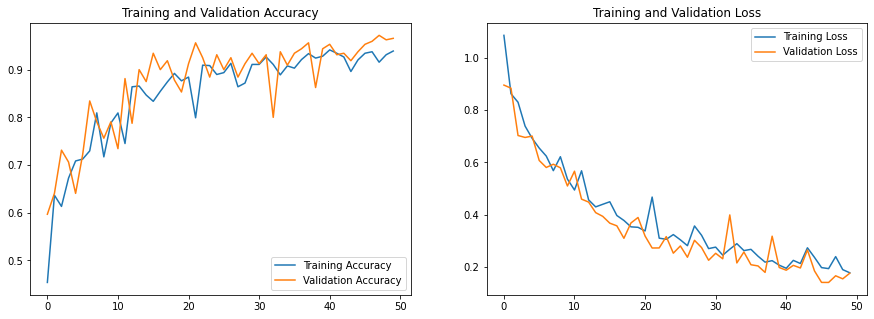

In [12]:
import matplotlib.pyplot as plt

# Akurasi
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Loss
loss = history.history['loss']
validation_loss = history.history['val_loss']

# Jumlah epoch
epochs_range = range(len(history.history['accuracy']))

# Plotting metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

### Testing Model

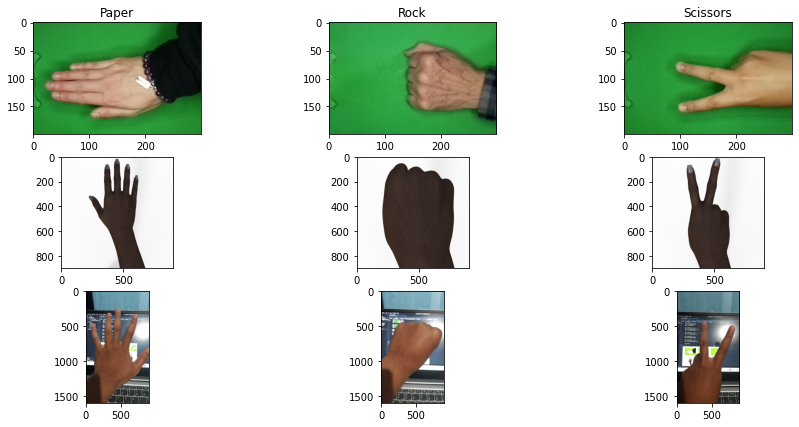

In [13]:
import matplotlib.pyplot as plt

# Backgroung hijau
img_paper_1 = plt.imread('./Dataset/Testing_Model/1fKclJk4eBWOQSR1.png')
img_rock_1 = plt.imread('./Dataset/Testing_Model/1mnAKQCHEDbtjPX2.png')
img_scissors_1 = plt.imread('./Dataset/Testing_Model/1L1n6plr7jlZGirw.png')

# Backgroung putih
img_paper_2 = plt.imread('./Dataset/Testing_Model/paper-hires1.png')
img_rock_2 = plt.imread('./Dataset/Testing_Model/rock-hires1.png')
img_scissors_2 = plt.imread('./Dataset/Testing_Model/scissors-hires1.png')

# Tangan sendiri
img_paper_3 = plt.imread('./Dataset/Testing_Model/paper-sendiri.jpeg')
img_rock_3 = plt.imread('./Dataset/Testing_Model/rock-sendiri.jpeg')
img_scissors_3 = plt.imread('./Dataset/Testing_Model/scissors-sendiri.jpeg')

plt.figure(figsize=(15, 7))

plt.subplot(3, 3, 1)
plt.imshow(img_paper_1)
plt.title('Paper')

plt.subplot(3, 3, 2)
plt.imshow(img_rock_1)
plt.title('Rock')

plt.subplot(3, 3, 3)
plt.imshow(img_scissors_1)
plt.title('Scissors')

plt.subplot(3, 3, 4)
plt.imshow(img_paper_2)

plt.subplot(3, 3, 5)
plt.imshow(img_rock_2)

plt.subplot(3, 3, 6)
plt.imshow(img_scissors_2)

plt.subplot(3, 3, 7)
plt.imshow(img_paper_3)

plt.subplot(3, 3, 8)
plt.imshow(img_rock_3)

plt.subplot(3, 3, 9)
plt.imshow(img_scissors_3)

plt.show()

In [14]:
import numpy as np
from tensorflow.keras.preprocessing import image

def convertImage(img) :
    gambar = image.load_img(img, target_size=(150, 150))
    gambar_array = image.img_to_array(gambar)
    gambar_batch = np.expand_dims(gambar_array, axis=0)
    gambar_preproses = np.vstack([gambar_batch])

    return gambar_preproses

In [15]:
# Backgroung hijau
img_paper_1 = './Dataset/Testing_Model/1fKclJk4eBWOQSR1.png'
img_rock_1 = './Dataset/Testing_Model/1mnAKQCHEDbtjPX2.png'
img_scissors_1 = './Dataset/Testing_Model/1L1n6plr7jlZGirw.png'

# Backgroung putih
img_paper_2 = './Dataset/Testing_Model/paper-hires1.png'
img_rock_2 = './Dataset/Testing_Model/rock-hires1.png'
img_scissors_2 = './Dataset/Testing_Model/scissors-hires1.png'

# Tangan sendiri
img_paper_3 = './Dataset/Testing_Model/paper-sendiri.jpeg'
img_rock_3 = './Dataset/Testing_Model/rock-sendiri.jpeg'
img_scissors_3 = './Dataset/Testing_Model/scissors-sendiri.jpeg'

prediction = modelCNN_ResNet.predict(convertImage(img_rock_3), batch_size=10)
output_class = np.argmax(prediction)

if output_class == 0:
    print('Paper')
elif output_class == 1:
    print('Rock')
else:
    print('Scissors')

Paper
